In [105]:
from web3 import Web3
from datetime import datetime
import pandas as pd
import requests
import json
from IPython.display import Image

In [106]:
infura_url= 'https://polygon-mainnet.infura.io/v3/[YOUR KEY]'
web3= Web3(Web3.HTTPProvider (infura_url))
web3.isConnected()

True

In [107]:
sc_address="0xF25212E676D1F7F89Cd72fFEe66158f541246445" ## https://docs.compound.finance/#developer-resources 
with open ("./ctoken_abi.json") as f:
    abi= json.load (f)

In [108]:
ctokenContract = web3.eth.contract(address=sc_address, abi=abi)

In [109]:
ctokenContract.all_functions()

[<Function absorb(address,address[])>,
 <Function accrueAccount(address)>,
 <Function approveThis(address,address,uint256)>,
 <Function balanceOf(address)>,
 <Function baseBorrowMin()>,
 <Function baseMinForRewards()>,
 <Function baseScale()>,
 <Function baseToken()>,
 <Function baseTokenPriceFeed()>,
 <Function baseTrackingBorrowSpeed()>,
 <Function baseTrackingSupplySpeed()>,
 <Function borrowBalanceOf(address)>,
 <Function borrowKink()>,
 <Function borrowPerSecondInterestRateBase()>,
 <Function borrowPerSecondInterestRateSlopeHigh()>,
 <Function borrowPerSecondInterestRateSlopeLow()>,
 <Function buyCollateral(address,uint256,uint256,address)>,
 <Function decimals()>,
 <Function extensionDelegate()>,
 <Function getAssetInfo(uint8)>,
 <Function getAssetInfoByAddress(address)>,
 <Function getBorrowRate(uint256)>,
 <Function getCollateralReserves(address)>,
 <Function getPrice(address)>,
 <Function getReserves()>,
 <Function getSupplyRate(uint256)>,
 <Function getUtilization()>,
 <Funct

In [110]:
##Basic data

In [63]:
decimal=ctokenContract.functions.decimals().call()
asset_number=ctokenContract.functions.numAssets().call()

In [100]:
decimal=ctokenContract.functions.decimals().call()
decimal

6

In [83]:
for x in range (0,asset_number):
   # print (ctokenContract.functions.getAssetInfo(x).call())
    print ('collateral_order',ctokenContract.functions.getAssetInfo(x).call()[0])
    print ('collateral_token',ctokenContract.functions.getAssetInfo(x).call()[1])
    print ('chainlink_price_feed',ctokenContract.functions.getAssetInfo(x).call()[2])
    print ('------------------------------------------------')

collateral_order 0
collateral_token 0x7ceB23fD6bC0adD59E62ac25578270cFf1b9f619
chainlink_price_feed 0xF9680D99D6C9589e2a93a78A04A279e509205945
------------------------------------------------
collateral_order 1
collateral_token 0x1BFD67037B42Cf73acF2047067bd4F2C47D9BfD6
chainlink_price_feed 0xDE31F8bFBD8c84b5360CFACCa3539B938dd78ae6
------------------------------------------------
collateral_order 2
collateral_token 0x0d500B1d8E8eF31E21C99d1Db9A6444d3ADf1270
chainlink_price_feed 0xAB594600376Ec9fD91F8e885dADF0CE036862dE0
------------------------------------------------


In [60]:
collateral0='0x7ceB23fD6bC0adD59E62ac25578270cFf1b9f619' ###Wrapped Ether
collateral1='0x1BFD67037B42Cf73acF2047067bd4F2C47D9BfD6' ###Wrapped Bitcoin
collateral2='0x0d500B1d8E8eF31E21C99d1Db9A6444d3ADf1270' ###WMatic
basetoken= ctokenContract.functions.baseToken().call()
collateral_list=[collateral0, collateral1, collateral2,basetoken]
tvl={}
with open ("./erc20_abi.json") as f:
    erc_abi= json.load (f)
for collateral in collateral_list:
    collateralcontract = web3.eth.contract(address=collateral, abi=erc_abi)
    decimal=collateralcontract.functions.decimals().call()
    locked= (collateralcontract.functions.balanceOf(sc_address).call())*10**-(int(decimal))
    print (collateralcontract.functions.name().call(), locked)
    tvl[collateralcontract.functions.name().call()]=locked

(PoS) Wrapped BTC 595.78446307
Wrapped Ether 7531.341128725864
Wrapped Matic 3586508.6568912677
USD Coin (PoS) 5419955.259935999


In [42]:
url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
btc_price = requests.get(url).json()["bitcoin"]["usd"]

url = "https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd"
eth_price = requests.get(url).json()["ethereum"]["usd"]

url = "https://api.coingecko.com/api/v3/simple/price?ids=matic-network&vs_currencies=usd"
matic_price = requests.get(url).json()["matic-network"]["usd"]

url = "https://api.coingecko.com/api/v3/simple/price?ids=usd-coin&vs_currencies=usd"
usdc_price = requests.get(url).json()["usd-coin"]["usd"]

In [43]:
prices_dic={'(PoS) Wrapped BTC':btc_price, 
         'Wrapped Ether': eth_price,
         'Wrapped Matic': matic_price,
        'USD Coin (PoS)': usdc_price}

In [39]:
df=pd.DataFrame.from_dict(tvl, orient='index', columns=['token_amount'])

In [44]:
df['price'] = df.index.map(prices_dic)

In [45]:
df.head()

,token_amount,price
(PoS) Wrapped BTC,5.957845e+02,29895.000000
Wrapped Ether,7.531341e+03,1874.150000
Wrapped Matic,3.586509e+06,0.749631
USD Coin (PoS),5.419955e+06,0.999911


In [46]:
df['amount_usd']=df['token_amount']*df['price']

In [49]:
tvl=df.amount_usd.sum()
tvl

40033870.45477115

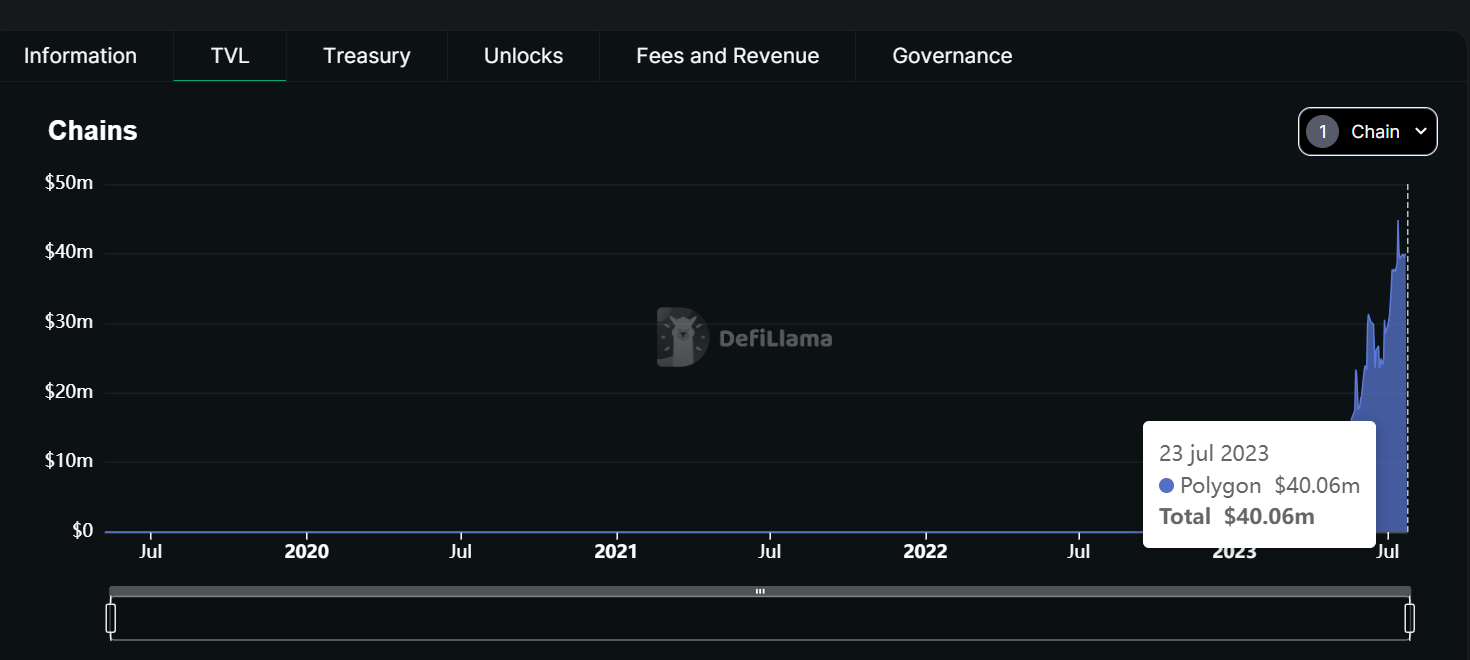

In [53]:
Image(filename='defi_lama_tvl.png') ### Source: defillama

In [88]:
total_collateral = df['amount_usd'].iloc[:-1].sum()
total_collateral

34614397.570853285

In [65]:
total_borrow= ctokenContract.functions.totalBorrow().call()*10**-int (decimal)
total_borrow

17841155.532107

In [91]:
loan_to_deposit_ratio= (total_borrow/total_collateral)*100
loan_to_deposit_ratio

51.54258569887684

In [64]:
total_earning= ctokenContract.functions.totalSupply().call()*10**-int (decimal)
total_earning

23235883.687459998

In [89]:
utilization=ctokenContract.functions.getUtilization().call()*10**-18
utilization*100

76.78302486511905

In [87]:
ctokenContract.functions.getReserves().call()*10**-decimal

25239.343365